# Diabetic Retinopathy Classification

In this notebook I trained Inception v3 model using dataset that rescaled only, without any image processing.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!nvidia-smi

Mon Dec 14 21:46:45 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1070   WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P8    12W / 151W |    343MiB /  8192MiB |      1%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [3]:
# import library
import os
import datetime
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, metrics, losses, optimizers, models, callbacks, utils, initializers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt
plt.style.use('dark_background')

In [4]:
!dir "D:/Datasets/thesis_dr/aptos2019-blindness-detection/"

 Volume in drive D is Storage space
 Volume Serial Number is 3C35-EA61

 Directory of D:\Datasets\thesis_dr\aptos2019-blindness-detection

12/13/2020  01:48 AM    <DIR>          .
12/13/2020  01:48 AM    <DIR>          ..
03/20/2020  10:02 AM               124 desktop.ini
12/06/2020  07:57 AM         1,235,300 df_train_dhash.csv
12/06/2020  07:46 AM         1,235,300 df_train_duplicate.csv
12/14/2020  08:32 PM    <DIR>          models
12/18/2019  03:23 AM            28,938 sample_submission.csv
12/18/2019  03:23 AM            25,072 test.csv
10/10/2020  08:35 AM    <DIR>          test_images
12/18/2019  03:27 AM            54,948 train.csv
10/10/2020  08:35 AM    <DIR>          train_images
10/30/2020  07:20 PM    <DIR>          train_images_balance_mini
10/28/2020  11:42 PM    <DIR>          train_images_jpeg
12/11/2020  01:07 AM    <DIR>          train_images_rescaled_300
12/06/2020  07:20 AM    <DIR>          train_images_rescaled_300_btgraham
12/11/2020  01:07 AM    <DIR>          

In [5]:
# define our working directory
dir_base = 'D:/Datasets/thesis_dr/aptos2019-blindness-detection/'
dir_img = os.path.join(
    dir_base, 'train_images_rescaled_300')

if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/')) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/'))

In [6]:
image_shape = (299, 299, 3)
batch_size = 32
lr_init = 1e-4
epoch_init = 100
save_csv = 'log_training-20201214.csv'
save_EOE_train_head = 'EOE_classifier-20201214.h5'
save_best_train_head = 'best_classifier-20201214.h5'

# Prepare dataframe

- Split train & test
- Compute weight for each class

In [7]:
# load csv file that contains our image file name & its label
df = pd.read_csv(os.path.join(dir_base, 'df_train_dhash.csv'))
df

,id_code,diagnosis,is_exist,dhash,freq,keep
0,000c1434d8d7.png,2,True,4505549846649357848361897357201341356077337430...,1,yes
1,001639a390f0.png,4,True,2329637184878609198035515006640525134579216941...,1,yes
2,0024cdab0c1e.png,1,True,2423240825355712633243422248054645083667877231...,1,yes
3,002c21358ce6.png,0,True,6900833685078708622050523299339707984650415156...,1,yes
4,005b95c28852.png,0,True,1596672251484725956711788094558338750112176232...,1,yes
...,...,...,...,...,...,...
3657,ffa47f6a7bf4.png,2,True,1714415029888012417314661111083115996014360412...,1,yes
3658,ffc04fed30e6.png,0,True,1596672252599988637907833311359172559898032526...,1,yes
3659,ffcf7b45f213.png,2,True,2371174750225767638951270617106319090295289270...,1,yes
3660,ffd97f8cd5aa.png,0,True,4495615386714830418073151623371454397778002504...,1,yes


In [8]:
df.groupby('diagnosis')[['id_code']].count()

,id_code
diagnosis,
0,1805
1,370
2,999
3,193
4,295


In [9]:
df = df.loc[(df['keep'] == 'yes') & (df['is_exist'] == True),
            ['id_code', 'diagnosis']].reset_index(drop=True)
df = df.astype(str)
df

,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0
...,...,...
3493,ffa47f6a7bf4.png,2
3494,ffc04fed30e6.png,0
3495,ffcf7b45f213.png,2
3496,ffd97f8cd5aa.png,0


In [10]:
df.groupby('diagnosis').count()

,id_code
diagnosis,
0,1796
1,338
2,921
3,173
4,270


In [11]:
skf = StratifiedKFold(n_splits=5, random_state=12345, shuffle=True)
dict_kfold = dict()
counter = 1
for train_index, test_index in skf.split(df['id_code'], df['diagnosis']):
    dict_kfold['train_fold_' + str(counter)] = train_index
    dict_kfold['valid_fold_' + str(counter)] = test_index
    counter += 1

dict_kfold

{'train_fold_1': array([   1,    2,    3, ..., 3495, 3496, 3497]),
 'valid_fold_1': array([   0,    5,    9,   15,   26,   27,   28,   35,   38,   57,   62,
          72,   76,   95,   96,  101,  104,  112,  115,  119,  127,  133,
         137,  140,  144,  148,  154,  156,  158,  159,  175,  179,  185,
         186,  195,  198,  205,  215,  225,  227,  229,  230,  234,  246,
         255,  261,  266,  268,  269,  274,  275,  277,  280,  283,  287,
         289,  291,  306,  308,  318,  322,  328,  329,  333,  341,  344,
         349,  354,  366,  374,  379,  381,  383,  395,  403,  407,  411,
         421,  423,  425,  451,  452,  453,  457,  458,  460,  463,  468,
         479,  487,  496,  502,  509,  510,  514,  517,  519,  526,  537,
         538,  544,  549,  550,  553,  556,  564,  567,  571,  576,  578,
         579,  583,  588,  590,  592,  593,  595,  601,  602,  606,  607,
         611,  616,  618,  623,  629,  631,  635,  637,  652,  653,  656,
         658,  662,  664,  66

In [12]:
df_train, df_valid = df.iloc[dict_kfold['train_fold_1']
                             ], df.iloc[dict_kfold['valid_fold_1']]
df_train.groupby('diagnosis').count()

,id_code
diagnosis,
0,1437
1,271
2,736
3,138
4,216


In [13]:
df_valid.groupby('diagnosis').count()

,id_code
diagnosis,
0,359
1,67
2,185
3,35
4,54


In [14]:
class_label = np.array(np.unique(df['diagnosis']))
class_label

array(['0', '1', '2', '3', '4'], dtype=object)

In [15]:
diagnosis = np.array(df['diagnosis'])
diagnosis.shape

(3498,)

In [16]:
# create class weight because our dataset is imbalance
class_weight = compute_class_weight('balanced', class_label, diagnosis)

dict_class_weight = dict()
for i in range(5):
    dict_class_weight[i] = class_weight[i]
dict_class_weight

C:\Users\fur_e\miniconda3\envs\tf2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=['0' '1' '2' '3' '4'], y=['2' '4' '1' ... '2' '0' '2'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


{0: 0.38953229398663697,
 1: 2.0698224852071005,
 2: 0.7596091205211727,
 3: 4.043930635838151,
 4: 2.591111111111111}

# Define Model

In [17]:
def create_model():
    conv_base = InceptionV3(
        include_top=False, weights=None, input_shape=(image_shape))
    conv_base.trainable = True

    input_layer = keras.Input(shape=image_shape)
    x = preprocess_input(input_layer)
    x = conv_base(x)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5, seed=123)(x)
    x = layers.Dense(512, kernel_initializer=initializers.GlorotUniform(
        seed=123), kernel_regularizer='l2', bias_regularizer='l2')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Dropout(0.5, seed=321)(x)
    x = layers.Dense(
        5, kernel_initializer=initializers.GlorotUniform(seed=321))(x)
    output_layer = layers.Activation('softmax')(x)
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return conv_base, model

In [18]:
my_metrics = [
    metrics.CategoricalAccuracy(),
    metrics.Precision(),
    metrics.Recall(),
    metrics.AUC()]

In [19]:
# define plot function
def plot_loss(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='valid loss')
    plt.title('Training & Valid Loss')
    plt.legend()
    plt.show()


def plot_acc(history):
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='valid acc')
    plt.title('Training & Valid Accuracy')
    plt.legend()
    plt.show()


def plot_precision(history):
    precision = history.history['precision']
    val_precision = history.history['val_precision']
    epochs = range(1, len(precision) + 1)

    plt.plot(epochs, precision, label='training precision')
    plt.plot(epochs, val_precision, label='valid precision')
    plt.title('Training & Valid Precision')
    plt.legend()
    plt.show()


def plot_recall(history):
    recall = history.history['recall']
    val_recall = history.history['val_recall']
    epochs = range(1, len(recall) + 1)

    plt.plot(epochs, recall, label='training recall')
    plt.plot(epochs, val_recall, label='valid recall')
    plt.title('Training & Valid Recall')
    plt.legend()
    plt.show()


def plot_auc(history):
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs = range(1, len(auc) + 1)

    plt.plot(epochs, auc, label='training auc')
    plt.plot(epochs, val_auc, label='valid auc')
    plt.title('Training & Valid AUC')
    plt.legend()
    plt.show()

# Define Image Generator

In [20]:
# we minimize the augmentation, in case preprocessing is destroyed?
train_datagen = image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='reflect',
    horizontal_flip=True,
    vertical_flip=True,
    data_format='channels_last')

test_datagen = image.ImageDataGenerator(
    data_format='channels_last')

In [21]:
def generator_builder(train_df, valid_df):
    generator_train = train_datagen.flow_from_dataframe(
        train_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=123)

    generator_valid = test_datagen.flow_from_dataframe(
        valid_df,
        directory=dir_img,
        x_col='id_code',
        y_col='diagnosis',
        target_size=image_shape[:2],
        class_mode='categorical',
        batch_size=batch_size,
        shuffle=True,
        seed=321)
    return generator_train, generator_valid

## Check training dataset

In [22]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [23]:
train_generator[0][0].shape

(32, 299, 299, 3)

In [24]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

0

In [25]:
fname = train_generator.filenames[image_idx]
fname

'ea5c42a78979.png'

In [26]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
3233,ea5c42a78979.png,0


In [27]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

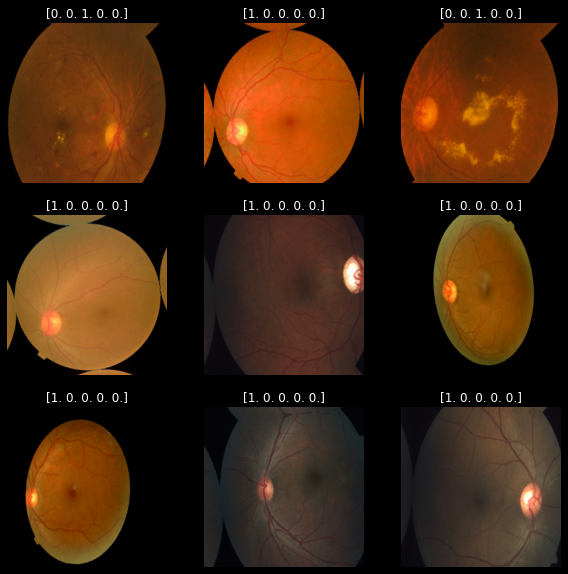

In [28]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Check validation dataset

In [29]:
valid_generator[0][0].shape

(32, 299, 299, 3)

In [30]:
image_idx = valid_generator.index_array[1]
valid_generator.labels[image_idx]

0

In [31]:
fname = valid_generator.filenames[image_idx]
fname

'a44345b27804.png'

In [32]:
df.loc[df['id_code'] == fname]

,id_code,diagnosis
2261,a44345b27804.png,0


In [33]:
valid_images_7, valid_labels_7 = valid_generator[7]
print(valid_images_7.shape)
print(valid_labels_7.shape)

(32, 299, 299, 3)
(32, 5)


<function matplotlib.pyplot.show(close=None, block=None)>

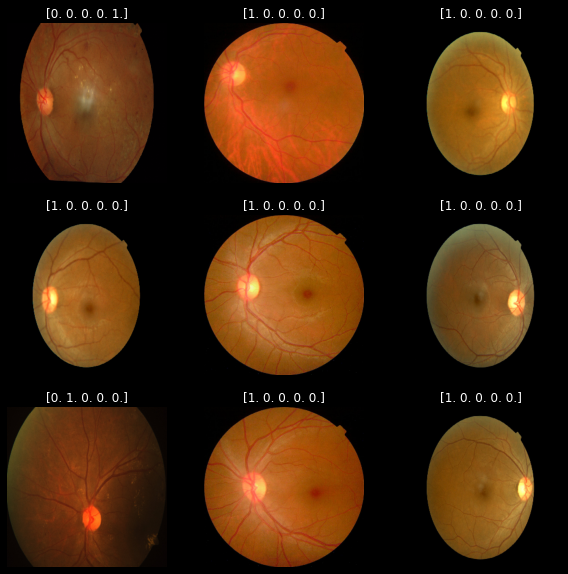

In [34]:
plt.figure(figsize=(10, 10))

for idx in range(9):
    ax = plt.subplot(3, 3, idx + 1)
    plt.imshow(image.array_to_img(valid_images_7[idx]))
    plt.title(str(valid_labels_7[idx]))
    plt.axis('off')

plt.show

# Fold 1

## Train classifier

In [35]:
fold = 1
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [36]:
df_valid.head(3)

,id_code,diagnosis
0,000c1434d8d7.png,2
5,0083ee8054ee.png,4
9,00cb6555d108.png,1


In [37]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))

In [38]:
conv_base, model = create_model()

In [39]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [40]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [41]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/100
87/88 [============================>.] - ETA: 2s - loss: 10.8544 - categorical_accuracy: 0.3547 - precision: 0.4413 - recall: 0.2093 - auc: 0.6493
Epoch 00001: val_loss improved from inf to 10.43721, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold1\best_classifier-20201214.h5
88/88 [==============================] - 274s 3s/step - loss: 10.8529 - categorical_accuracy: 0.3549 - precision: 0.4408 - recall: 0.2091 - auc: 0.6493 - val_loss: 10.4372 - val_categorical_accuracy: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3655
Epoch 2/100
87/88 [============================>.] - ETA: 2s - loss: 10.2079 - categorical_accuracy: 0.4541 - precision: 0.6267 - recall: 0.3040 - auc: 0.7420
Epoch 00002: val_loss improved from 10.43721 to 10.09692, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/

Epoch 28/100
87/88 [============================>.] - ETA: 1s - loss: 2.5852 - categorical_accuracy: 0.6403 - precision: 0.7828 - recall: 0.5224 - auc: 0.9037
Epoch 00028: val_loss improved from 2.94233 to 2.85000, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold1\best_classifier-20201214.h5
88/88 [==============================] - 140s 2s/step - loss: 2.5803 - categorical_accuracy: 0.6408 - precision: 0.7829 - recall: 0.5232 - auc: 0.9042 - val_loss: 2.8500 - val_categorical_accuracy: 0.6214 - val_precision: 0.7568 - val_recall: 0.5200 - val_auc: 0.8954
Epoch 29/100
87/88 [============================>.] - ETA: 1s - loss: 2.4790 - categorical_accuracy: 0.6417 - precision: 0.7583 - recall: 0.5343 - auc: 0.9043
Epoch 00029: val_loss did not improve from 2.85000
88/88 [==============================] - 135s 2s/step - loss: 2.4818 - categorical_accuracy: 0.6419 - precision: 0.7585 - recall: 0.5343 - auc: 0.9043 - val_loss: 3.0777 - val_categ

88/88 [==============================] - 139s 2s/step - loss: 1.3737 - categorical_accuracy: 0.7066 - precision: 0.7956 - recall: 0.6176 - auc: 0.9332 - val_loss: 1.9869 - val_categorical_accuracy: 0.6086 - val_precision: 0.6311 - val_recall: 0.5400 - val_auc: 0.8792
Epoch 44/100
87/88 [============================>.] - ETA: 1s - loss: 1.3301 - categorical_accuracy: 0.7072 - precision: 0.7755 - recall: 0.6381 - auc: 0.9310
Epoch 00044: val_loss did not improve from 1.98693
88/88 [==============================] - 136s 2s/step - loss: 1.3349 - categorical_accuracy: 0.7066 - precision: 0.7763 - recall: 0.6376 - auc: 0.9309 - val_loss: 2.4892 - val_categorical_accuracy: 0.5571 - val_precision: 0.6205 - val_recall: 0.4929 - val_auc: 0.8426
Epoch 45/100
87/88 [============================>.] - ETA: 1s - loss: 1.2533 - categorical_accuracy: 0.7075 - precision: 0.7754 - recall: 0.6341 - auc: 0.9339
Epoch 00045: val_loss did not improve from 1.98693
88/88 [==============================] - 136

Epoch 60/100
87/88 [============================>.] - ETA: 1s - loss: 0.8572 - categorical_accuracy: 0.7664 - precision: 0.8063 - recall: 0.7238 - auc: 0.9558
Epoch 00060: val_loss did not improve from 1.66734
88/88 [==============================] - 135s 2s/step - loss: 0.8580 - categorical_accuracy: 0.7659 - precision: 0.8069 - recall: 0.7227 - auc: 0.9556 - val_loss: 1.8497 - val_categorical_accuracy: 0.5486 - val_precision: 0.5880 - val_recall: 0.4914 - val_auc: 0.8505
Epoch 61/100
87/88 [============================>.] - ETA: 1s - loss: 0.8913 - categorical_accuracy: 0.7458 - precision: 0.7885 - recall: 0.6996 - auc: 0.9501
Epoch 00061: val_loss did not improve from 1.66734
88/88 [==============================] - 134s 2s/step - loss: 0.8902 - categorical_accuracy: 0.7462 - precision: 0.7883 - recall: 0.7001 - auc: 0.9500 - val_loss: 2.0007 - val_categorical_accuracy: 0.6386 - val_precision: 0.6836 - val_recall: 0.6143 - val_auc: 0.9027
Epoch 62/100
87/88 [========================

87/88 [============================>.] - ETA: 1s - loss: 0.6998 - categorical_accuracy: 0.7892 - precision: 0.8155 - recall: 0.7607 - auc: 0.9634
Epoch 00094: val_loss did not improve from 1.66734
88/88 [==============================] - 136s 2s/step - loss: 0.6958 - categorical_accuracy: 0.7906 - precision: 0.8166 - recall: 0.7623 - auc: 0.9639 - val_loss: 2.2982 - val_categorical_accuracy: 0.6086 - val_precision: 0.6271 - val_recall: 0.5886 - val_auc: 0.8695
Epoch 95/100
87/88 [============================>.] - ETA: 1s - loss: 0.5689 - categorical_accuracy: 0.8453 - precision: 0.8658 - recall: 0.8232 - auc: 0.9752
Epoch 00095: val_loss did not improve from 1.66734
88/88 [==============================] - 135s 2s/step - loss: 0.5753 - categorical_accuracy: 0.8452 - precision: 0.8658 - recall: 0.8231 - auc: 0.9751 - val_loss: 2.0129 - val_categorical_accuracy: 0.6386 - val_precision: 0.6621 - val_recall: 0.6186 - val_auc: 0.8971
Epoch 96/100
87/88 [============================>.] - ETA

In [42]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

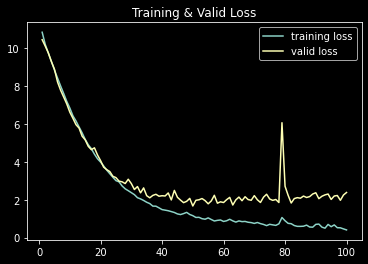

In [43]:
plot_loss(history)

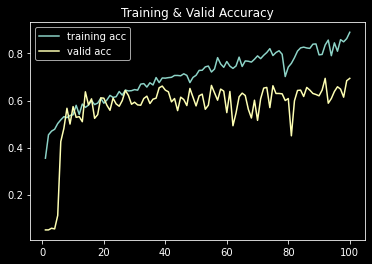

In [44]:
plot_acc(history)

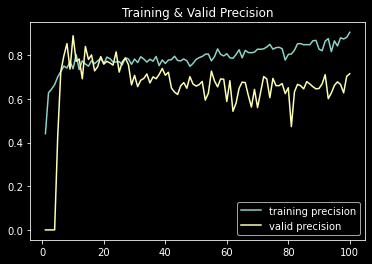

In [45]:
plot_precision(history)

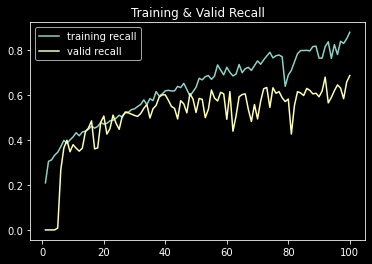

In [46]:
plot_recall(history)

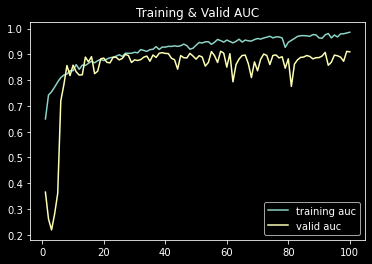

In [47]:
plot_auc(history)

### Evaluate model

In [48]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 636ms/step - loss: 1.2607 - categorical_accuracy: 0.6943 - precision: 0.7154 - recall: 0.6857 - auc: 0.9097


[1.2607026411728426, 0.6942857, 0.7153502, 0.6857143, 0.909696]

In [49]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [50]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 582ms/step


In [51]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.97      0.95       359
         mild       0.44      0.52      0.48        67
     moderate       0.56      0.45      0.50       185
       severe       0.12      0.14      0.13        35
proliferative       0.25      0.24      0.24        54

     accuracy                           0.69       700
    macro avg       0.46      0.47      0.46       700
 weighted avg       0.69      0.69      0.69       700



In [52]:
confusion_matrix(y_true, y_pred)

array([[350,   5,   2,   1,   1],
       [  5,  35,  21,   2,   4],
       [ 14,  32,  83,  26,  30],
       [  2,   1,  22,   5,   5],
       [  5,   7,  21,   8,  13]], dtype=int64)

# Fold 2

## Train classifier

In [53]:
del(model)

In [54]:
fold = 2
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [55]:
df_valid.head(3)

,id_code,diagnosis
1,001639a390f0.png,4
3,002c21358ce6.png,0
11,00e4ddff966a.png,2


In [56]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))

In [57]:
conv_base, model = create_model()

In [58]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_1 (TensorFl [(None, 299, 299, 3) 0           input_4[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_1 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_1[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_1[0][0]          
____________________________________________________________________________________________

In [59]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [60]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/100
87/88 [============================>.] - ETA: 1s - loss: 10.9093 - categorical_accuracy: 0.3322 - precision: 0.3713 - recall: 0.1649 - auc: 0.6197
Epoch 00001: val_loss improved from inf to 10.35160, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold2\best_classifier-20201214.h5
88/88 [==============================] - 161s 2s/step - loss: 10.9087 - categorical_accuracy: 0.3310 - precision: 0.3706 - recall: 0.1637 - auc: 0.6196 - val_loss: 10.3516 - val_categorical_accuracy: 0.0771 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2277
Epoch 2/100
87/88 [============================>.] - ETA: 1s - loss: 10.2525 - categorical_accuracy: 0.4248 - precision: 0.5624 - recall: 0.2509 - auc: 0.7154
Epoch 00002: val_loss improved from 10.35160 to 10.12852, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/

Epoch 28/100
87/88 [============================>.] - ETA: 1s - loss: 2.3147 - categorical_accuracy: 0.6667 - precision: 0.7616 - recall: 0.5694 - auc: 0.9216
Epoch 00028: val_loss improved from 2.94241 to 2.68855, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold2\best_classifier-20201214.h5
88/88 [==============================] - 142s 2s/step - loss: 2.3132 - categorical_accuracy: 0.6669 - precision: 0.7611 - recall: 0.5693 - auc: 0.9217 - val_loss: 2.6885 - val_categorical_accuracy: 0.6186 - val_precision: 0.6885 - val_recall: 0.5557 - val_auc: 0.8971
Epoch 29/100
87/88 [============================>.] - ETA: 1s - loss: 2.1800 - categorical_accuracy: 0.6743 - precision: 0.7659 - recall: 0.5868 - auc: 0.9241
Epoch 00029: val_loss improved from 2.68855 to 2.55073, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold2\best_classifier-20201214.h5
88/88 [==============================] - 144s 2s/s

Epoch 43/100
87/88 [============================>.] - ETA: 1s - loss: 1.1527 - categorical_accuracy: 0.7296 - precision: 0.7879 - recall: 0.6663 - auc: 0.9437
Epoch 00043: val_loss did not improve from 1.88271
88/88 [==============================] - 135s 2s/step - loss: 1.1523 - categorical_accuracy: 0.7291 - precision: 0.7880 - recall: 0.6655 - auc: 0.9436 - val_loss: 1.9150 - val_categorical_accuracy: 0.6129 - val_precision: 0.6496 - val_recall: 0.5614 - val_auc: 0.8933
Epoch 44/100
87/88 [============================>.] - ETA: 1s - loss: 1.1289 - categorical_accuracy: 0.7281 - precision: 0.7750 - recall: 0.6623 - auc: 0.9433
Epoch 00044: val_loss did not improve from 1.88271
88/88 [==============================] - 135s 2s/step - loss: 1.1362 - categorical_accuracy: 0.7266 - precision: 0.7729 - recall: 0.6605 - auc: 0.9430 - val_loss: 2.0387 - val_categorical_accuracy: 0.6057 - val_precision: 0.6598 - val_recall: 0.5514 - val_auc: 0.8785
Epoch 45/100
87/88 [========================

87/88 [============================>.] - ETA: 1s - loss: 0.7277 - categorical_accuracy: 0.7921 - precision: 0.8219 - recall: 0.7556 - auc: 0.9619
Epoch 00077: val_loss did not improve from 1.88271
88/88 [==============================] - 135s 2s/step - loss: 0.7302 - categorical_accuracy: 0.7927 - precision: 0.8221 - recall: 0.7566 - auc: 0.9620 - val_loss: 2.0816 - val_categorical_accuracy: 0.5671 - val_precision: 0.5926 - val_recall: 0.5257 - val_auc: 0.8538
Epoch 78/100
87/88 [============================>.] - ETA: 1s - loss: 0.7601 - categorical_accuracy: 0.7672 - precision: 0.8039 - recall: 0.7393 - auc: 0.9590
Epoch 00078: val_loss did not improve from 1.88271
88/88 [==============================] - 135s 2s/step - loss: 0.7603 - categorical_accuracy: 0.7677 - precision: 0.8041 - recall: 0.7395 - auc: 0.9590 - val_loss: 2.5110 - val_categorical_accuracy: 0.6371 - val_precision: 0.6715 - val_recall: 0.6014 - val_auc: 0.8883
Epoch 79/100
87/88 [============================>.] - ETA

Epoch 94/100
87/88 [============================>.] - ETA: 1s - loss: 0.4769 - categorical_accuracy: 0.8651 - precision: 0.8825 - recall: 0.8496 - auc: 0.9821
Epoch 00094: val_loss did not improve from 1.86264
88/88 [==============================] - 136s 2s/step - loss: 0.4747 - categorical_accuracy: 0.8663 - precision: 0.8834 - recall: 0.8506 - auc: 0.9823 - val_loss: 2.0796 - val_categorical_accuracy: 0.6814 - val_precision: 0.7031 - val_recall: 0.6700 - val_auc: 0.9059
Epoch 95/100
87/88 [============================>.] - ETA: 1s - loss: 0.4179 - categorical_accuracy: 0.8897 - precision: 0.9023 - recall: 0.8811 - auc: 0.9859
Epoch 00095: val_loss did not improve from 1.86264
88/88 [==============================] - 136s 2s/step - loss: 0.4165 - categorical_accuracy: 0.8903 - precision: 0.9027 - recall: 0.8817 - auc: 0.9860 - val_loss: 2.4132 - val_categorical_accuracy: 0.6514 - val_precision: 0.6592 - val_recall: 0.6300 - val_auc: 0.8790
Epoch 96/100
87/88 [========================

In [61]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

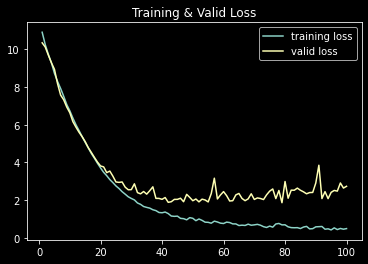

In [62]:
plot_loss(history)

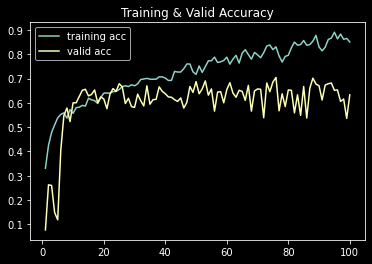

In [63]:
plot_acc(history)

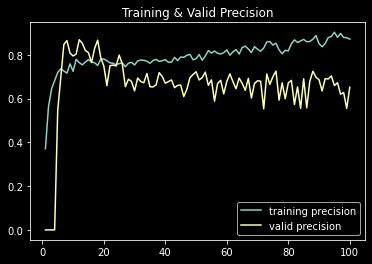

In [64]:
plot_precision(history)

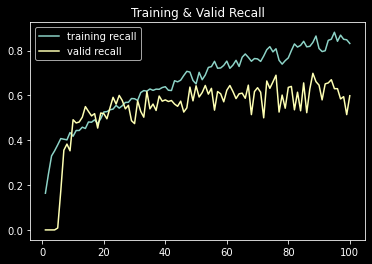

In [65]:
plot_recall(history)

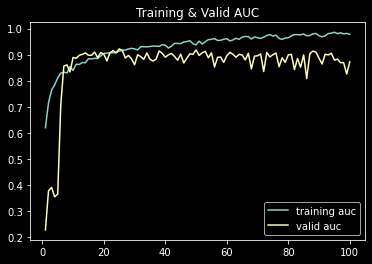

In [66]:
plot_auc(history)

### Evaluate model

In [67]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 645ms/step - loss: 1.5325 - categorical_accuracy: 0.6329 - precision: 0.6516 - recall: 0.5986 - auc: 0.8726


[1.5325219468636946, 0.63285714, 0.65163296, 0.5985714, 0.87257606]

In [68]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [69]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 581ms/step


In [70]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.93      0.81      0.87       359
         mild       0.36      0.50      0.42        68
     moderate       0.54      0.54      0.54       184
       severe       0.13      0.17      0.15        35
proliferative       0.20      0.22      0.21        54

     accuracy                           0.63       700
    macro avg       0.43      0.45      0.44       700
 weighted avg       0.67      0.63      0.65       700



In [71]:
confusion_matrix(y_true, y_pred)

array([[292,  10,  24,  14,  19],
       [  5,  34,  20,   5,   4],
       [ 11,  40,  99,  17,  17],
       [  4,   3,  14,   6,   8],
       [  3,   8,  26,   5,  12]], dtype=int64)

# Fold 3

## Train classifier

In [72]:
del(model)

In [73]:
fold = 3
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2798 validated image filenames belonging to 5 classes.
Found 700 validated image filenames belonging to 5 classes.


In [74]:
df_valid.head(3)

,id_code,diagnosis
2,0024cdab0c1e.png,1
12,00f6c1be5a33.png,0
18,0151781fe50b.png,0


In [75]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))

In [76]:
conv_base, model = create_model()

In [77]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_2 (TensorFl [(None, 299, 299, 3) 0           input_6[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_2 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_2[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_2[0][0]          
____________________________________________________________________________________________

In [78]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [79]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/100
87/88 [============================>.] - ETA: 1s - loss: 10.8323 - categorical_accuracy: 0.3344 - precision: 0.3936 - recall: 0.1558 - auc: 0.6331
Epoch 00001: val_loss improved from inf to 10.47786, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold3\best_classifier-20201214.h5
88/88 [==============================] - 169s 2s/step - loss: 10.8199 - categorical_accuracy: 0.3360 - precision: 0.3982 - recall: 0.1580 - auc: 0.6345 - val_loss: 10.4779 - val_categorical_accuracy: 0.0500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.2243
Epoch 2/100
87/88 [============================>.] - ETA: 1s - loss: 10.2368 - categorical_accuracy: 0.3988 - precision: 0.5184 - recall: 0.2140 - auc: 0.6899
Epoch 00002: val_loss improved from 10.47786 to 10.03440, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/

Epoch 28/100
87/88 [============================>.] - ETA: 1s - loss: 2.3570 - categorical_accuracy: 0.6645 - precision: 0.7725 - recall: 0.5611 - auc: 0.9146
Epoch 00028: val_loss improved from 3.08973 to 2.94541, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold3\best_classifier-20201214.h5
88/88 [==============================] - 139s 2s/step - loss: 2.3595 - categorical_accuracy: 0.6637 - precision: 0.7718 - recall: 0.5608 - auc: 0.9145 - val_loss: 2.9454 - val_categorical_accuracy: 0.5300 - val_precision: 0.6444 - val_recall: 0.4271 - val_auc: 0.8304
Epoch 29/100
87/88 [============================>.] - ETA: 1s - loss: 2.2108 - categorical_accuracy: 0.6678 - precision: 0.7747 - recall: 0.5669 - auc: 0.9174
Epoch 00029: val_loss improved from 2.94541 to 2.68682, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold3\best_classifier-20201214.h5
88/88 [==============================] - 139s 2s/s

Epoch 60/100
87/88 [============================>.] - ETA: 1s - loss: 0.6845 - categorical_accuracy: 0.8120 - precision: 0.8462 - recall: 0.7798 - auc: 0.9680
Epoch 00060: val_loss did not improve from 2.13542
88/88 [==============================] - 135s 2s/step - loss: 0.6846 - categorical_accuracy: 0.8109 - precision: 0.8452 - recall: 0.7784 - auc: 0.9678 - val_loss: 2.6517 - val_categorical_accuracy: 0.6057 - val_precision: 0.6392 - val_recall: 0.5871 - val_auc: 0.8786
Epoch 61/100
87/88 [============================>.] - ETA: 1s - loss: 0.7001 - categorical_accuracy: 0.8138 - precision: 0.8452 - recall: 0.7874 - auc: 0.9681
Epoch 00061: val_loss did not improve from 2.13542
88/88 [==============================] - 135s 2s/step - loss: 0.7089 - categorical_accuracy: 0.8120 - precision: 0.8435 - recall: 0.7859 - auc: 0.9678 - val_loss: 2.5902 - val_categorical_accuracy: 0.5929 - val_precision: 0.6142 - val_recall: 0.5686 - val_auc: 0.8624
Epoch 62/100
87/88 [========================

87/88 [============================>.] - ETA: 1s - loss: 0.5302 - categorical_accuracy: 0.8554 - precision: 0.8792 - recall: 0.8391 - auc: 0.9788
Epoch 00094: val_loss did not improve from 2.13542
88/88 [==============================] - 134s 2s/step - loss: 0.5327 - categorical_accuracy: 0.8560 - precision: 0.8794 - recall: 0.8392 - auc: 0.9790 - val_loss: 3.7071 - val_categorical_accuracy: 0.6486 - val_precision: 0.6753 - val_recall: 0.6357 - val_auc: 0.8800
Epoch 95/100
87/88 [============================>.] - ETA: 1s - loss: 0.4680 - categorical_accuracy: 0.8698 - precision: 0.8892 - recall: 0.8500 - auc: 0.9821
Epoch 00095: val_loss did not improve from 2.13542
88/88 [==============================] - 134s 2s/step - loss: 0.4690 - categorical_accuracy: 0.8706 - precision: 0.8901 - recall: 0.8510 - auc: 0.9820 - val_loss: 2.7995 - val_categorical_accuracy: 0.5800 - val_precision: 0.6117 - val_recall: 0.5671 - val_auc: 0.8652
Epoch 96/100
87/88 [============================>.] - ETA

In [80]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

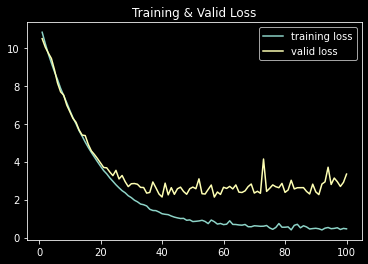

In [81]:
plot_loss(history)

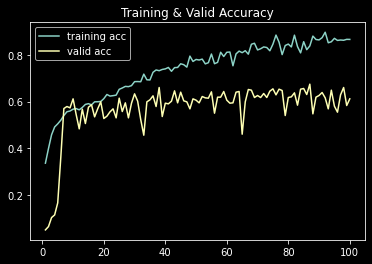

In [82]:
plot_acc(history)

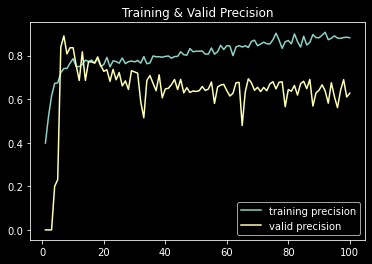

In [83]:
plot_precision(history)

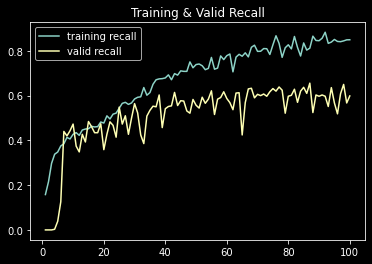

In [84]:
plot_recall(history)

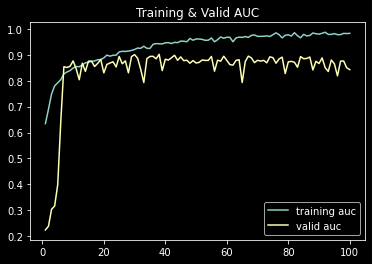

In [85]:
plot_auc(history)

### Evaluate model

In [86]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 635ms/step - loss: 2.1488 - categorical_accuracy: 0.6114 - precision: 0.6272 - recall: 0.5986 - auc: 0.8428


[2.1487835862419824, 0.61142856, 0.6272455, 0.5985714, 0.8428455]

In [87]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [88]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 578ms/step


In [89]:
print(classification_report(y_true, y_pred, target_names=[
      'normal', 'mild', 'moderate', 'severe', 'proliferative']))

               precision    recall  f1-score   support

       normal       0.90      0.82      0.86       359
         mild       0.28      0.31      0.29        68
     moderate       0.43      0.53      0.47       184
       severe       0.17      0.14      0.15        35
proliferative       0.24      0.19      0.21        54

     accuracy                           0.61       700
    macro avg       0.40      0.40      0.40       700
 weighted avg       0.63      0.61      0.62       700



In [90]:
confusion_matrix(y_true, y_pred)

array([[295,  11,  47,   1,   5],
       [  6,  21,  34,   1,   6],
       [ 17,  31,  97,  19,  20],
       [  6,   4,  19,   5,   1],
       [  2,   8,  30,   4,  10]], dtype=int64)

# Fold 4

## Train classifier

In [91]:
del(model)

In [92]:
fold = 4
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [93]:
df_valid.head(3)

,id_code,diagnosis
4,005b95c28852.png,0
10,00cc2b75cddd.png,0
13,0104b032c141.png,3


In [94]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))

In [95]:
conv_base, model = create_model()

In [96]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_3 (TensorFl [(None, 299, 299, 3) 0           input_8[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub_3 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_3[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_3[0][0]          
____________________________________________________________________________________________

In [97]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [98]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/100
87/88 [============================>.] - ETA: 1s - loss: 10.7208 - categorical_accuracy: 0.3578 - precision: 0.4619 - recall: 0.1840 - auc: 0.6661
Epoch 00001: val_loss improved from inf to 10.29219, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold4\best_classifier-20201214.h5
88/88 [==============================] - 188s 2s/step - loss: 10.7189 - categorical_accuracy: 0.3583 - precision: 0.4606 - recall: 0.1836 - auc: 0.6663 - val_loss: 10.2922 - val_categorical_accuracy: 0.0486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3728
Epoch 2/100
87/88 [============================>.] - ETA: 1s - loss: 10.1339 - categorical_accuracy: 0.4333 - precision: 0.5818 - recall: 0.2519 - auc: 0.7202
Epoch 00002: val_loss improved from 10.29219 to 9.96659, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/k

Epoch 28/100
87/88 [============================>.] - ETA: 1s - loss: 2.2467 - categorical_accuracy: 0.6874 - precision: 0.7688 - recall: 0.5960 - auc: 0.9250
Epoch 00028: val_loss improved from 3.07310 to 2.93105, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold4\best_classifier-20201214.h5
88/88 [==============================] - 140s 2s/step - loss: 2.2435 - categorical_accuracy: 0.6870 - precision: 0.7689 - recall: 0.5956 - auc: 0.9251 - val_loss: 2.9310 - val_categorical_accuracy: 0.6252 - val_precision: 0.7116 - val_recall: 0.5508 - val_auc: 0.8832
Epoch 29/100
87/88 [============================>.] - ETA: 1s - loss: 2.1927 - categorical_accuracy: 0.6841 - precision: 0.7649 - recall: 0.5974 - auc: 0.9212
Epoch 00029: val_loss improved from 2.93105 to 2.66995, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold4\best_classifier-20201214.h5
88/88 [==============================] - 140s 2s/s

Epoch 43/100
87/88 [============================>.] - ETA: 1s - loss: 1.1233 - categorical_accuracy: 0.7521 - precision: 0.8011 - recall: 0.6943 - auc: 0.9494
Epoch 00043: val_loss did not improve from 2.19329
88/88 [==============================] - 136s 2s/step - loss: 1.1217 - categorical_accuracy: 0.7524 - precision: 0.8007 - recall: 0.6949 - auc: 0.9496 - val_loss: 2.3237 - val_categorical_accuracy: 0.6438 - val_precision: 0.6972 - val_recall: 0.6094 - val_auc: 0.8879
Epoch 44/100
87/88 [============================>.] - ETA: 1s - loss: 1.1361 - categorical_accuracy: 0.7416 - precision: 0.7886 - recall: 0.6957 - auc: 0.9481
Epoch 00044: val_loss did not improve from 2.19329
88/88 [==============================] - 136s 2s/step - loss: 1.1366 - categorical_accuracy: 0.7413 - precision: 0.7890 - recall: 0.6960 - auc: 0.9480 - val_loss: 3.1837 - val_categorical_accuracy: 0.5451 - val_precision: 0.5840 - val_recall: 0.5122 - val_auc: 0.8495
Epoch 45/100
87/88 [========================

Epoch 60/100
87/88 [============================>.] - ETA: 1s - loss: 0.7637 - categorical_accuracy: 0.7951 - precision: 0.8234 - recall: 0.7564 - auc: 0.9616
Epoch 00060: val_loss did not improve from 2.07685
88/88 [==============================] - 134s 2s/step - loss: 0.7661 - categorical_accuracy: 0.7953 - precision: 0.8236 - recall: 0.7571 - auc: 0.9615 - val_loss: 4.6874 - val_categorical_accuracy: 0.6180 - val_precision: 0.6454 - val_recall: 0.5937 - val_auc: 0.8422
Epoch 61/100
87/88 [============================>.] - ETA: 1s - loss: 0.7581 - categorical_accuracy: 0.7842 - precision: 0.8208 - recall: 0.7532 - auc: 0.9644
Epoch 00061: val_loss did not improve from 2.07685
88/88 [==============================] - 134s 2s/step - loss: 0.7573 - categorical_accuracy: 0.7849 - precision: 0.8213 - recall: 0.7538 - auc: 0.9647 - val_loss: 2.1530 - val_categorical_accuracy: 0.6037 - val_precision: 0.6482 - val_recall: 0.5694 - val_auc: 0.8828
Epoch 62/100
87/88 [========================

Epoch 77/100
87/88 [============================>.] - ETA: 1s - loss: 0.4980 - categorical_accuracy: 0.8605 - precision: 0.8766 - recall: 0.8417 - auc: 0.9812
Epoch 00077: val_loss did not improve from 1.92220
88/88 [==============================] - 135s 2s/step - loss: 0.5042 - categorical_accuracy: 0.8600 - precision: 0.8761 - recall: 0.8414 - auc: 0.9808 - val_loss: 2.6461 - val_categorical_accuracy: 0.5422 - val_precision: 0.5678 - val_recall: 0.5093 - val_auc: 0.8224
Epoch 78/100
87/88 [============================>.] - ETA: 1s - loss: 0.5112 - categorical_accuracy: 0.8486 - precision: 0.8685 - recall: 0.8330 - auc: 0.9797
Epoch 00078: val_loss did not improve from 1.92220
88/88 [==============================] - 134s 2s/step - loss: 0.5119 - categorical_accuracy: 0.8496 - precision: 0.8693 - recall: 0.8342 - auc: 0.9797 - val_loss: 2.3309 - val_categorical_accuracy: 0.6366 - val_precision: 0.6636 - val_recall: 0.6123 - val_auc: 0.8831
Epoch 79/100
87/88 [========================

In [99]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

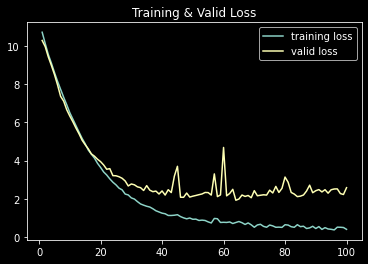

In [100]:
plot_loss(history)

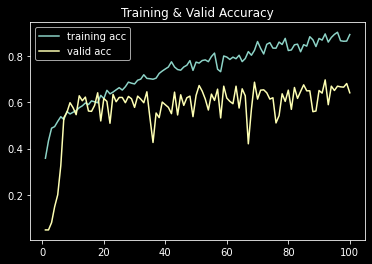

In [101]:
plot_acc(history)

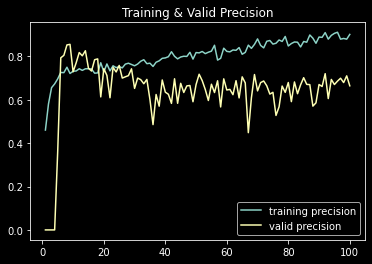

In [102]:
plot_precision(history)

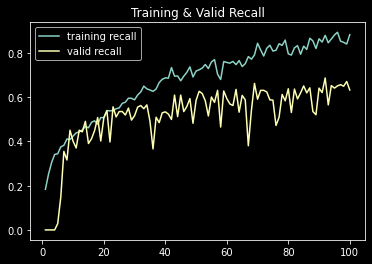

In [103]:
plot_recall(history)

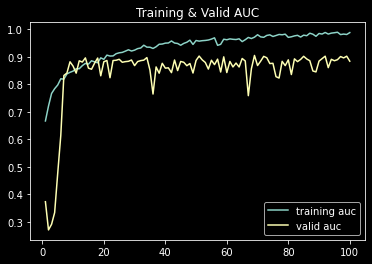

In [104]:
plot_auc(history)

### Evaluate model

In [105]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 641ms/step - loss: 1.6175 - categorical_accuracy: 0.6409 - precision: 0.6647 - recall: 0.6323 - auc: 0.8836


[1.6174552115527066, 0.6409156, 0.66466165, 0.6323319, 0.8835714]

In [106]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [107]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 581ms/step


In [108]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.86      0.90       359
         mild       0.25      0.37      0.30        68
     moderate       0.56      0.51      0.53       184
       severe       0.15      0.24      0.18        34
proliferative       0.27      0.26      0.26        54

     accuracy                           0.64       699
    macro avg       0.43      0.45      0.43       699
 weighted avg       0.69      0.64      0.66       699



In [109]:
confusion_matrix(y_true, y_pred)

array([[307,  25,  12,   9,   6],
       [  4,  25,  30,   5,   4],
       [ 11,  33,  94,  24,  22],
       [  1,   7,  12,   8,   6],
       [  1,   9,  21,   9,  14]], dtype=int64)

# Fold 5

## Train classifier

In [110]:
del(model)

In [111]:
fold = 5
df_train = df.iloc[dict_kfold['train_fold_'+str(fold)]]
df_valid = df.iloc[dict_kfold['valid_fold_'+str(fold)]]
train_generator, valid_generator = generator_builder(df_train, df_valid)

Found 2799 validated image filenames belonging to 5 classes.
Found 699 validated image filenames belonging to 5 classes.


In [112]:
df_valid.head(3)

,id_code,diagnosis
6,0097f532ac9f.png,0
7,00a8624548a9.png,2
8,00b74780d31d.png,2


In [113]:
if os.path.isdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))) == False:
    os.mkdir(os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold)))

save_dir = os.path.join(dir_base, 'models/kfold_end_to_end/fold'+str(fold))

In [114]:
conv_base, model = create_model()

In [115]:
model.compile(
    optimizer=optimizers.Adam(learning_rate=lr_init),
    loss=losses.CategoricalCrossentropy(),
    metrics=my_metrics)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv_4 (TensorFl [(None, 299, 299, 3) 0           input_10[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_sub_4 (TensorFlowOp [(None, 299, 299, 3) 0           tf_op_layer_truediv_4[0][0]      
__________________________________________________________________________________________________
inception_v3 (Model)            (None, 8, 8, 2048)   21802784    tf_op_layer_sub_4[0][0]          
____________________________________________________________________________________________

In [116]:
my_callbacks = [
    callbacks.CSVLogger(
        os.path.join(save_dir, save_csv), separator=',', append=True),
    callbacks.ModelCheckpoint(
        os.path.join(save_dir, save_best_train_head), monitor='val_loss', mode='min', save_best_only=True, verbose=1)]

In [117]:
history = model.fit(
    train_generator,
    epochs=epoch_init,
    validation_data=valid_generator,
    class_weight=dict_class_weight,
    callbacks=my_callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 88 steps, validate for 22 steps
Epoch 1/100
87/88 [============================>.] - ETA: 2s - loss: 10.8741 - categorical_accuracy: 0.3191 - precision: 0.3904 - recall: 0.1673 - auc: 0.6290
Epoch 00001: val_loss improved from inf to 10.38370, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold5\best_classifier-20201214.h5
88/88 [==============================] - 223s 3s/step - loss: 10.8690 - categorical_accuracy: 0.3198 - precision: 0.3921 - recall: 0.1676 - auc: 0.6294 - val_loss: 10.3837 - val_categorical_accuracy: 0.0486 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4312
Epoch 2/100
87/88 [============================>.] - ETA: 1s - loss: 10.3034 - categorical_accuracy: 0.3997 - precision: 0.4940 - recall: 0.2082 - auc: 0.6854
Epoch 00002: val_loss improved from 10.38370 to 9.98201, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/k

Epoch 28/100
87/88 [============================>.] - ETA: 1s - loss: 2.4777 - categorical_accuracy: 0.6729 - precision: 0.7561 - recall: 0.5905 - auc: 0.9260
Epoch 00028: val_loss did not improve from 3.10233
88/88 [==============================] - 134s 2s/step - loss: 2.4746 - categorical_accuracy: 0.6742 - precision: 0.7578 - recall: 0.5913 - auc: 0.9264 - val_loss: 3.1565 - val_categorical_accuracy: 0.6080 - val_precision: 0.6731 - val_recall: 0.5479 - val_auc: 0.8881
Epoch 29/100
87/88 [============================>.] - ETA: 1s - loss: 2.3814 - categorical_accuracy: 0.6823 - precision: 0.7625 - recall: 0.5988 - auc: 0.9245
Epoch 00029: val_loss improved from 3.10233 to 2.75109, saving model to D:/Datasets/thesis_dr/aptos2019-blindness-detection/models/kfold_end_to_end/fold5\best_classifier-20201214.h5
88/88 [==============================] - 141s 2s/step - loss: 2.3794 - categorical_accuracy: 0.6838 - precision: 0.7641 - recall: 0.6006 - auc: 0.9252 - val_loss: 2.7511 - val_categ

Epoch 44/100
87/88 [============================>.] - ETA: 1s - loss: 1.1603 - categorical_accuracy: 0.7333 - precision: 0.7793 - recall: 0.6802 - auc: 0.9481
Epoch 00044: val_loss did not improve from 2.11626
88/88 [==============================] - 134s 2s/step - loss: 1.1636 - categorical_accuracy: 0.7320 - precision: 0.7781 - recall: 0.6788 - auc: 0.9478 - val_loss: 2.4464 - val_categorical_accuracy: 0.4549 - val_precision: 0.5026 - val_recall: 0.4092 - val_auc: 0.7953
Epoch 45/100
87/88 [============================>.] - ETA: 1s - loss: 1.0936 - categorical_accuracy: 0.7495 - precision: 0.7872 - recall: 0.6899 - auc: 0.9519
Epoch 00045: val_loss did not improve from 2.11626
88/88 [==============================] - 134s 2s/step - loss: 1.1013 - categorical_accuracy: 0.7485 - precision: 0.7868 - recall: 0.6895 - auc: 0.9518 - val_loss: 2.3889 - val_categorical_accuracy: 0.6338 - val_precision: 0.6645 - val_recall: 0.5951 - val_auc: 0.8951
Epoch 46/100
87/88 [========================

Epoch 61/100
87/88 [============================>.] - ETA: 1s - loss: 0.7376 - categorical_accuracy: 0.8164 - precision: 0.8432 - recall: 0.7889 - auc: 0.9672
Epoch 00061: val_loss did not improve from 1.97905
88/88 [==============================] - 147s 2s/step - loss: 0.7413 - categorical_accuracy: 0.8153 - precision: 0.8423 - recall: 0.7881 - auc: 0.9669 - val_loss: 2.2283 - val_categorical_accuracy: 0.6123 - val_precision: 0.6372 - val_recall: 0.5880 - val_auc: 0.8828
Epoch 62/100
87/88 [============================>.] - ETA: 1s - loss: 0.9428 - categorical_accuracy: 0.7239 - precision: 0.7710 - recall: 0.6765 - auc: 0.9400
Epoch 00062: val_loss did not improve from 1.97905
88/88 [==============================] - 138s 2s/step - loss: 0.9382 - categorical_accuracy: 0.7249 - precision: 0.7717 - recall: 0.6774 - auc: 0.9403 - val_loss: 4.6005 - val_categorical_accuracy: 0.6152 - val_precision: 0.6434 - val_recall: 0.5937 - val_auc: 0.8615
Epoch 63/100
87/88 [========================

Epoch 78/100
87/88 [============================>.] - ETA: 1s - loss: 0.5457 - categorical_accuracy: 0.8464 - precision: 0.8678 - recall: 0.8229 - auc: 0.9777
Epoch 00078: val_loss did not improve from 1.93559
88/88 [==============================] - 137s 2s/step - loss: 0.5449 - categorical_accuracy: 0.8464 - precision: 0.8675 - recall: 0.8232 - auc: 0.9776 - val_loss: 2.2858 - val_categorical_accuracy: 0.6338 - val_precision: 0.6677 - val_recall: 0.6152 - val_auc: 0.8870
Epoch 79/100
87/88 [============================>.] - ETA: 1s - loss: 0.5441 - categorical_accuracy: 0.8478 - precision: 0.8738 - recall: 0.8233 - auc: 0.9763
Epoch 00079: val_loss did not improve from 1.93559
88/88 [==============================] - 137s 2s/step - loss: 0.5474 - categorical_accuracy: 0.8471 - precision: 0.8729 - recall: 0.8221 - auc: 0.9761 - val_loss: 2.3430 - val_categorical_accuracy: 0.6481 - val_precision: 0.6692 - val_recall: 0.6252 - val_auc: 0.8892
Epoch 80/100
87/88 [========================

In [118]:
model.save(os.path.join(save_dir, save_EOE_train_head))

### Plot training result

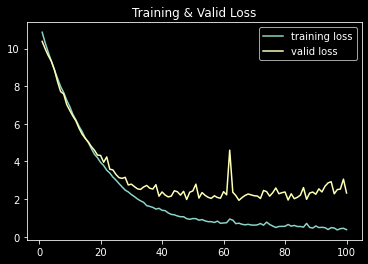

In [119]:
plot_loss(history)

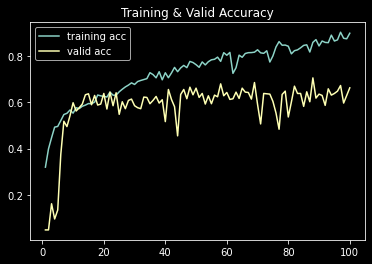

In [120]:
plot_acc(history)

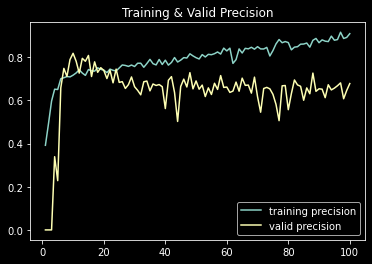

In [121]:
plot_precision(history)

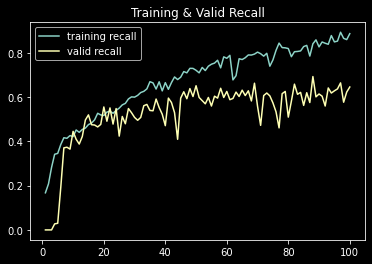

In [122]:
plot_recall(history)

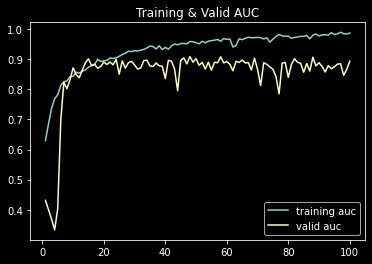

In [123]:
plot_auc(history)

### Evaluate model

In [124]:
model.evaluate(valid_generator, verbose=1)

  ...
    to  
  ['...']
22/22 [==============================] - 14s 650ms/step - loss: 1.3206 - categorical_accuracy: 0.6624 - precision: 0.6782 - recall: 0.6452 - auc: 0.8933


[1.3206119347702374, 0.6623748, 0.6781955, 0.64520746, 0.8932892]

In [125]:
y_true = list()
for idx in range(len(valid_generator.index_array)):
    img_idx = valid_generator.index_array[idx]
    y_true.append(valid_generator.labels[img_idx])

In [126]:
y_pred_prob = model.predict(valid_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

22/22 [==============================] - 13s 588ms/step


In [127]:
print(classification_report(y_true, y_pred, target_names=['normal', 'mild', 'moderate','severe','proliferative']))

               precision    recall  f1-score   support

       normal       0.95      0.92      0.94       360
         mild       0.34      0.49      0.40        67
     moderate       0.54      0.41      0.46       184
       severe       0.22      0.29      0.25        34
proliferative       0.19      0.24      0.21        54

     accuracy                           0.66       699
    macro avg       0.45      0.47      0.45       699
 weighted avg       0.69      0.66      0.67       699



In [128]:
confusion_matrix(y_true, y_pred)

array([[332,   5,  18,   3,   2],
       [  4,  33,  16,   7,   7],
       [  9,  42,  75,  20,  38],
       [  0,   5,  11,  10,   8],
       [  4,  12,  20,   5,  13]], dtype=int64)